# AMATH 584 Homework 3
## Author: Marlin Figgins
## Date: Nov 2., 2020.

You can find and download the original notebook at [link](https://github.com/marlinfiggins/UW-AMATH-notes/tree/master/AMATH-584A-Applied-Linear-Algebra/notebooks).

In [1]:
using Plots, LinearAlgebra, LaTeXStrings, Distributions

# I. QR Decomposition

Develop a numerical algorithm that implements the modified Gram-Schmidt orthogonalization procedure. Compare your algorithm to (i) the `qrfactor.m` code that we built in class (you can download it from the third lecture on QR on the website), and (ii) MATLAB’s QR algorithm on a variety of matrices to see how well your algorithm works. Be sure to try it on a matrix that is ill-conditions i.e. $\text{cond}(\mathbf{A}) \gg 1$.

In [2]:
# Generating a tall and skinny test matrix
m = 7
n = 3
A = rand(m,n)

7×3 Array{Float64,2}:
 0.572856  0.471039  0.853853
 0.641943  0.046415  0.660265
 0.988592  0.313921  0.37523
 0.980215  0.247435  0.881273
 0.808836  0.830259  0.624969
 0.151372  0.321253  0.608352
 0.912851  0.755227  0.33625

## Modified Gram-Schmidt orthogonalization

The function below is an implementation of the QR factorization using modified Gram-Schmidt.

In [3]:
function qr_modified_GS(A)
    V = copy(A)
    
    m,n = size(A)
    R = zeros(m,n)
    Q = zeros(m,m)

    for i in 1:n
        R[i,i] = norm(V[:,i], 2)
        Q[:,i] = V[:,i]/R[i,i]
        for j in (i+1):n
            R[i,j] = Q[:,i]'*V[:,j]
            V[:,j] -= R[i,j]*Q[:,i]
        end
    end
    return Q, R
end

Q, R = qr_modified_GS(A)
A ≈ Q*R

true

## Refactoring `qrfactor.m` in Julia.

In [4]:
function qrfactor_m(M)
    A = copy(M)
    
    m,n = size(A)
    Q = Matrix{Float64}(I, m, m)
    for k in 1:n
        #Find Householder Reflector
        z = A[k:m, k]
        v = [-sign(z[1])*norm(z)- z[1]; -z[2:end]]
        v = v / sqrt(v'*v)
                
        # Apply reflector to each column of A and Q
        for j in 1:n
            A[k:m,j] -= v*(2*(v'*A[k:m,j]))
        end
        for j in 1:m
            Q[k:m,j] -= v*(2*(v'*Q[k:m,j]))
        end
    end
    # Output Q and R
    return Q', A
end

Q, R = qrfactor_m(A)
A ≈ Q*R

true

## Base Julia QR

We'll also test against the base QR method in Julia.

In [5]:
Q, R= qr(A)

A≈Q*R

true

## Comparing methods on ill-Conditioned matrices

## Vandermonde matrices

In [6]:
function vandermonde_mat(alpha)
    n = length(alpha)
    V = zeros(n, n)
    for i in 1:n
       V[i,:] .= [alpha[i]^(j-1) for j in 1:n] 
    end
    return V
end

V = vandermonde_mat(rand(Normal(), 50))
cond(V)

4.385520479148389e29

We will test our various $\mathbf{QR}$ factorizations on this ill-conditioned $50\times 50$ Vandermonde matrix.

In [7]:
# Testing MGS
Q, R = qr_modified_GS(V)
println("Modified GS test passed? $(V ≈ Q*R)")

Modified GS test passed? true


In [8]:
# Testing qfactor.m
Q, R = qrfactor_m(V)
V ≈ Q*R
println("qfactor.m test passed? $(V ≈ Q*R)")

qfactor.m test passed? true


In [9]:
# Testing Base
F = qr(V)
V≈F.Q*F.R
println("base julia test passed? $(V ≈ Q*R)")

base julia test passed? true


We'll now test these QR methods on random Vandermonde matrices with every $\alpha_i \sim \text{Normal}(0,1)$.

In [10]:
n = 50
test_num = 500

errors = zeros(test_num, 3)
conds = Float64[]
methods = [qr_modified_GS qrfactor_m qr]
method_names = ["qr_modified_GS" "qrfactor_m" "qr"]

for t in 1:test_num
    A = vandermonde_mat(rand(Normal(), n))
    push!(conds, cond(A))
    for i in eachindex(methods)
        Q,R = methods[i](A) # Compute QR decomposition
        errors[t,i] = norm(A-Q*R) # Compute norm of difference
    end
end

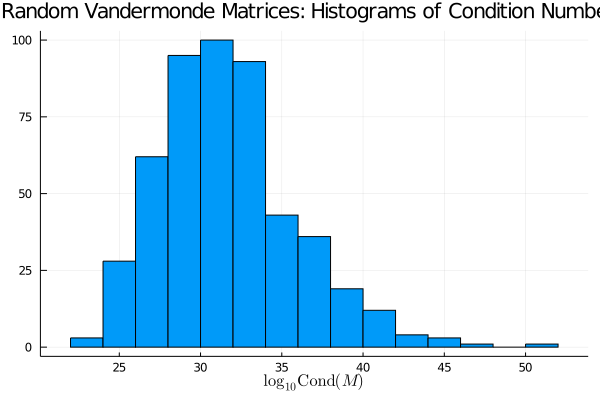

In [11]:
histogram(log10.(conds),
    xlabel = L"\log_{10}\textrm{Cond}(M)",
    legend=false,
    title = "Random Vandermonde Matrices: Histograms of Condition Numbers")

As you can see from the histogram above, the matrices we generated are ill-conditioned with very high condition numbers.

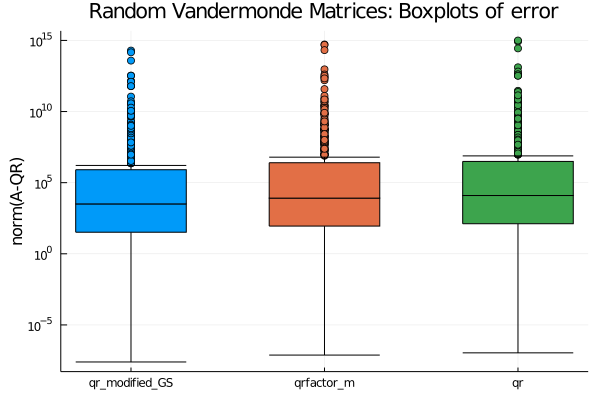

In [12]:
using StatsPlots
boxplot(method_names, errors, 
    label = method_names, 
    ylabel= "norm(A-QR)",
    yscale = :log10,
    legend = false,
    title = "Random Vandermonde Matrices: Boxplots of error")

There are several large outliers in the error, but all methods seem to be equally screwed up when used on ill-conditioned matrices.

## Random normal matrices
 
We will generate several $n \times n$ matrices with random normal entries, then compare each of the methods on these random matrices.

In [13]:
n = 100
test_num = 500

errors = zeros(test_num, 3)
conds = []
methods = [qr_modified_GS qrfactor_m qr]
method_names = ["qr_modified_GS" "qrfactor_m" "qr"]

for t in 1:test_num
    A = rand(Normal(), n,n) # Generate random n x n matrix
    push!(conds, cond(A))
    for i in eachindex(methods)
        Q,R = methods[i](A) # Compute QR decomposition
        errors[t,i] = norm(A-Q*R) # Compute norm of difference
    end
end

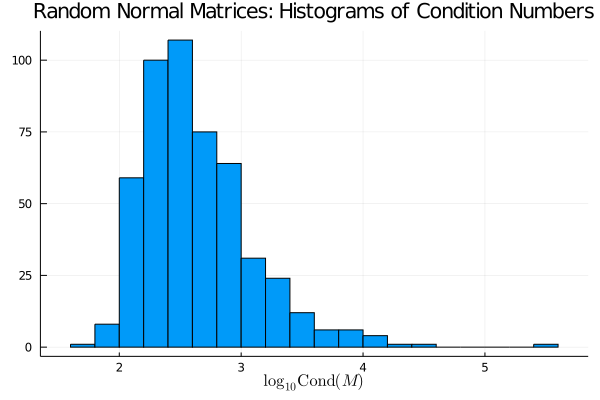

In [14]:
histogram(log10.(conds),
    xlabel = L"\log_{10}\textrm{Cond}(M)",
    legend = false,
    title = "Random Normal Matrices: Histograms of Condition Numbers")

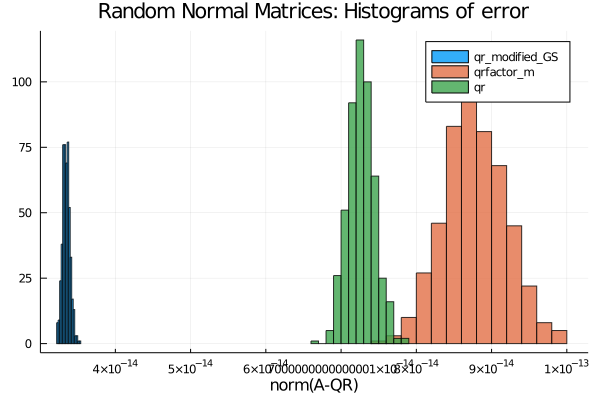

In [15]:
histogram(errors, 
    label = method_names, 
    alpha = 0.8,
    xlabel = "norm(A-QR)",
    title = "Random Normal Matrices: Histograms of error")

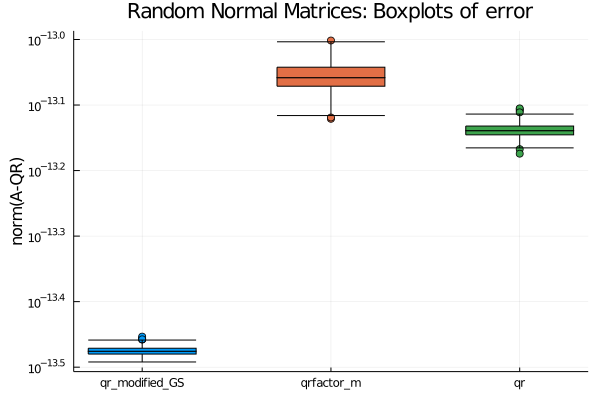

In [16]:
using StatsPlots
boxplot(method_names, errors, 
    label = method_names, 
    ylabel= "norm(A-QR)",
    yscale = :log10,
    legend = false,
    title = "Random Normal Matrices: Boxplots of error")

The methods appears to cluster and form distinct error distributions. We can see that all methods have an extremely low error on these matrices which is approximately $10^{-14}$! Strangely enough, the modified GS method appears to outperform the base QR method in julia, but I imagine the difference is really negligible. 

# II. Fun with polynomials

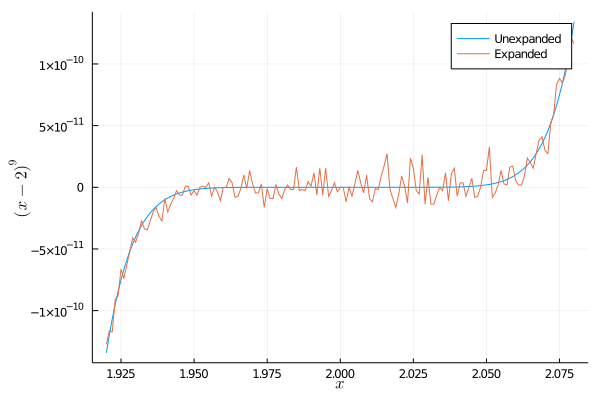

In [17]:
# x range
x = collect(1.920:0.001:2.080)

# Two representations of the sample polynomial
p1(x) = (x-2)^9
p2(x) = x^9 - 18*x^8 + 144*x^7 - 672*x^6 + 2016*x^5 - 4032*x^4 + 5376*x^3 - 4608*x^2 + 2304*x - 512

plot(x, p1.(x), label = "Unexpanded", 
    xlabel = L"x",
    ylabel = L"(x-2)^9")
plot!(x, p2.(x), label = "Expanded")

# III. Conditioning

## III.A.

Construct a random matrix of size $m \times n$ where $m > n$. Study the condition number as a function of the size of the matrix.

In [18]:
max_n = 1000
samples = 50
sizes = collect(1:100:max_n)
cond_mat = zeros(length(sizes), samples)

for k in 1:length(sizes)
    cond_vec = []
    for i in 1:samples
        M = rand(Normal(), sizes[k], sizes[k])
        cond_mat[k,i] = cond(M)
    end
end

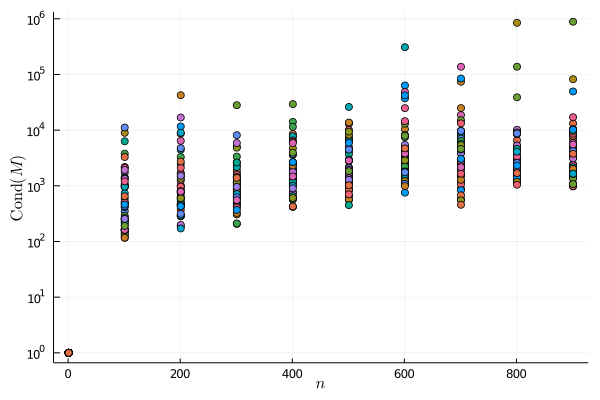

In [19]:
scatter(sizes,
    cond_mat,
    yscale=:log10,
    xlabel = L"n",
    label = false,
    ylabel = L"\textrm{Cond}(M)")

There doesn't appear to be a strong trend here since we're working on the log scale, but we can see that the condition number somewhat increases alongside the size of the matrix!

## III.B. 
In the case $m = n-1$, copy the first column of a matrix $A$ and append it as the (n+1)th column of $A$. What is the condition number and the determinant of the matrix?

In [20]:
n = 7
M = rand(Normal(), n-1,n)
M_clone = vcat(M,transpose(M[1,:]))
cond(M_clone)

1.0918621330012252e16

This has a high condition number!

## III.C.
Take the appended $(m+1)$-th column and add normally distributed noise to it, and see what happens to the condition number as a function of $\epsilon$. Here, noise is drawn $\text{Normal}(0, \epsilon^2)$

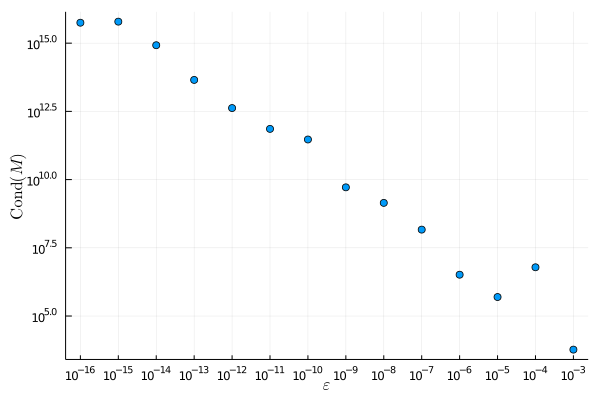

In [21]:
eps = [10.0^(-n) for n in 3:16] # Size of noise
cond_vec = Float64[]
for i in eachindex(eps)
    # Adding noisy replicate of first column
    M_noise_col = vcat(M,
                    transpose(M[1,:] + eps[i].*rand(Normal(), n)))
    
    push!(cond_vec, cond(M_noise_col))
end
scatter(eps, cond_vec, 
    scale=:log10, 
    label=false,
    xticks=eps,
    xlabel = L"\epsilon",
    ylabel = L"\textrm{Cond}(M)")

We see that even for small bits of noise the condition number begins to fall rapidly.